In [93]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# 1 Theory: plot the pressure contour and the streamline

In [94]:
# parameters
phi = 0.001
eps = 0.01
alpha = -0.001
Re = 1
x_len = 1.10
z_len = 1
h_in = 1
h_end = 1+ alpha/eps*x_len
# mesh grid
Z, X = np.mgrid[0:z_len:101j, 0:x_len:1001j]
Z = np.ma.masked_where(Z > 1+alpha/eps*X, Z)
X = np.ma.masked_where(Z > 1+alpha/eps*X, X)
h = 1 + alpha/eps*X

In [95]:
# Non-dimensional
dpdx = -3/(3*phi*h+h**2)
dpdx2 = (9*phi + 6*h)*alpha/eps/(3*phi*h+h**2)**2
p = (np.log(3*phi+h)-np.log(h))/(phi*alpha/eps)
p_range = np.max(p) - np.min(p)
p = (p - np.min(p))/p_range
# Horizontal velocity
u0 = -dpdx*(0.5*(h**2-Z**2)+phi*h)
u1 = ((0.5*h**2 + phi*h)**2*(Z**2-h**2)*0.5 + (Z**6-h**6)/360)*dpdx*dpdx2 
u1 += ((0.5*h**2 + phi*h)*(Z**2-h**2)*0.5 + (Z**4-h**4)/24)*(h+phi)*alpha/eps*dpdx**2
U = u0 + eps*Re*u1
# Vertical velocity
v0 = (h + phi)*alpha/eps*dpdx*Z - ((Z**3/6-h**2*Z/2-phi*h*Z))*dpdx2
V = v0 
# Velocity magnitude
Umag = np.sqrt(U**2 + V**2)

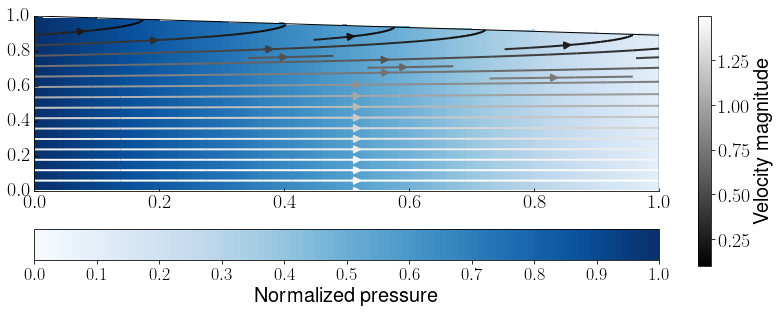

In [96]:
from mpl_toolkits.axisartist.axislines import SubplotZero
tickSize       = 18
labelFontSize  = 20
axis_font      = 15
fig = plt.figure(figsize=(14, 4.6))
ax1 = SubplotZero(fig, 1, 1, 1)
fig.add_subplot(ax1)
for n in ["top", "right"]:
    ax1.axis[n].set_visible(False)
    
plt.plot([0, 0, 1, 1],[0, h_in, h_end,0], color='k', linestyle='-', linewidth=1)

title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} 
ax1.set_adjustable(adjustable='datalim', share=False)

font = {'size': 15}

plt.rc('font', **font)

strm = ax1.streamplot(X, Z, U, V, 
                      arrowsize=1.5, density=[0.8, 0.6], color=Umag, linewidth=2, cmap='gray')

strm_bar = fig.colorbar(strm.lines)
strm_bar.set_label('Velocity magnitude',fontsize = labelFontSize)
strm_bar.ax.tick_params(labelsize=labelFontSize) 
ax1.set(ylim=(0, 1))
ax1.set(xlim=(0, 1))

con = ax1.contourf(X, Z, p, cmap="Blues",levels = 120)
p_tick = np.linspace(0, 1.0,11, endpoint=True)
p_bar = fig.colorbar(con,ticks=p_tick,orientation='horizontal')
p_bar.set_label('Normalized pressure',fontsize = labelFontSize)
p_bar.ax.tick_params(labelsize=tickSize) 
figure_folder = "./finalData/"
figure_name = "streamline.pdf"
figure_file_path = figure_folder + figure_name
plt.savefig(figure_file_path)

# 2. Simulation 

## 2.1 Grid independence test

In [120]:
from matplotlib import rc
# rc('text', usetex=True)
# ,**{'family':'sans-serif','sans-serif':['Helvetica']}
font = {'family' : 'sans-serif',
        'sans-serif':['Helvetica'],
        'weight' : 'heavy',
        'size': 20}

rc('font', **font) 

In [116]:
phi_ = 0.0001
Re_ = 10**(-5)
alpha_ = -0.0005
eps = 0.01
delta_ = alpha_/eps

# analytical solution: along X
ix = np.linspace(0,1,101)
ih = 1 + delta_*ix
dpdx = -3/(3*phi_*ih  + ih**2)
# dpdx2 = (9*phi_ + 6*ih)*alpha_/eps/(3*phi_*ih+ih**2)**2
iu = -dpdx*(phi_*ih)
iv = eps*(-ih*alpha_/eps/(3*phi_+ih))
vt=iv[50]
ut=iu[50]
dpdxt = dpdx[50]

def v_calc(file):    
    df = pd.read_csv("finalData/ind/"+ file)
       
    return  abs(df.iloc[50]['U:2']-vt)/vt, abs(df.iloc[50]['U:0']-ut)/ut,abs((10**(-5)*(df.iloc[51]['p']-df.iloc[50]['p'])-dpdxt)/dpdxt)

files = ["1_alongXa.csv","u_alongX_21.csv","u_alongX_42.csv","u_alongX_84.csv"] 

vws = []
uws = []
ps = []
for file in files:    
    v,u,p = v_calc(file)
    vws.append(v)
    uws.append(u)
    ps.append(p)
    

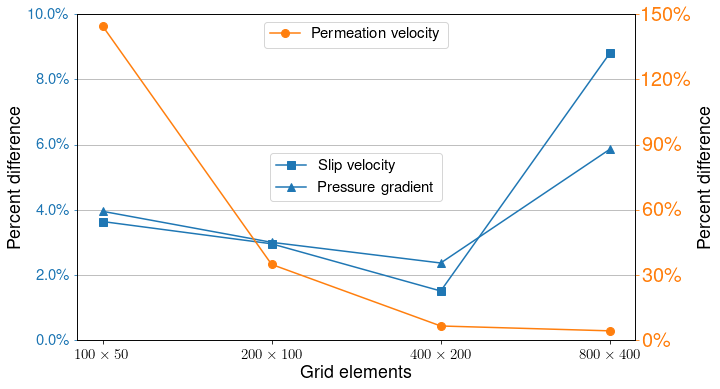

In [117]:
grids = [r'$100 \times 50$',r'$200 \times 100$',r'$400 \times 200$',r'$800 \times 400$'] 

# %matplotlib inline
figwidth       = 10
figheight      = 6
ms = 8

# 'burlywood''deepskyblue''salmon'
fig,ax1 = plt.subplots(figsize = (figwidth,figheight))   
ax1.plot(grids,(uws), '-s',ms = ms,color = 'C0',label = "Slip velocity")
ax1.plot(grids,(ps), '-^',ms = ms,color = 'C0',label = "Pressure gradient") #dp/dx
ax1.set_xlabel("Grid elements",fontsize='large', fontweight='bold')
ax1.set_ylabel("Percent difference",fontsize='large', fontweight='bold')
ax1.tick_params('y', colors='C0')
ax1.set_ylim([0,0.1])
ax1.legend(loc=10)
plt.grid(True, axis = 'y')

ax2 = ax1.twinx()
ax2.plot(grids,vws, '-o',ms = ms, color ='C1',label = "Permeation velocity")
ax2.set_ylabel("Percent difference", fontsize='large', fontweight='bold')
ax2.tick_params('y', colors='C1', labelsize=20)
ax2.set_ylim([0,1.5])
ax2.set_yticks(np.arange(0,1.51,0.3))

ax2.legend(loc = 9)

import matplotlib.ticker as ticker
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(1))
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(1))
figure_folder = "./finalData/ind/"
figure_name = "ind.pdf"
# figure_file_path = figure_folder + figure_name
# plt.savefig(figure_file_path)

# 2.2 Plot the veloctity profiles

In [6]:
# Simulation results
def Avg_val(fileNam,Re):
    """
    Create a dataframe to store all relevant parameters: x-coordinate, pressure, dpdx, ux, conductivity, at the 
    latest saved time (when the simulation reaches convergence).
    """
    df = pd.read_csv(fileName, sep='\t', names=['Time','Coord','p','gradPx','gradPy',
                                                             'gradPz','Ux','Uy','Uz','volume'])

    df = df[['Coord','gradPx', 'Ux','p']]
    df['gradPx'] *= Re # Non-dimensionalization
    df['conductivity'] = -df['Ux']/df['gradPx']*0.96
    df = df.reset_index()

    return df

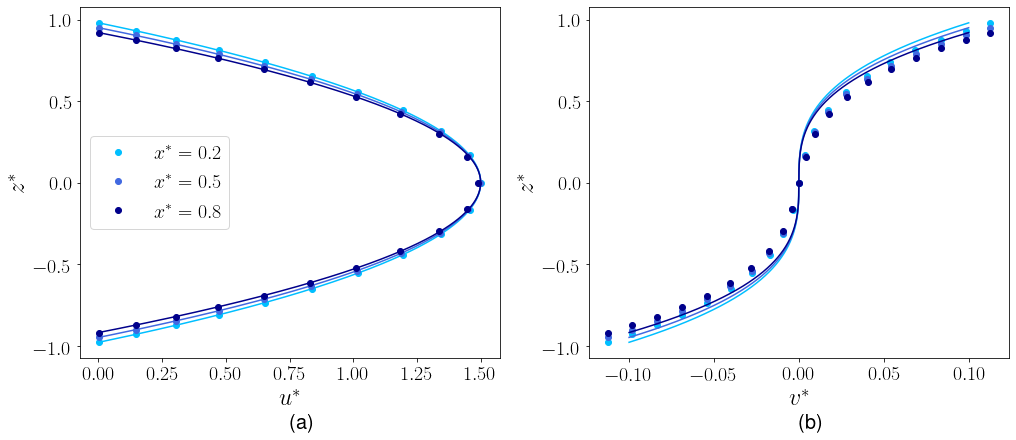

In [121]:
# Plot velocities along z-direction at x^* = 0.2, 0.5, 0.8
# phi = 0.0005, alpha = -0.001, Re = 1
colors = ['deepskyblue','royalblue','darkblue']
figwidth = 14
figheight = 6
fig = plt.figure(figsize=(figwidth,figheight),constrained_layout=True)
widths = [figwidth/2, figwidth/2]
heights = [figheight]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)
for col in range(2):
    axes[col] = fig.add_subplot(spec[0, col])
    
fileName = "finalData/dat_phi/geo"+str(3)+ "phi" + str(1)+"nu"+str(0) \
            +"_up.dat"
data = Avg_val(fileName,Re_)
u_norm = data.iloc[50]['Ux']

eps = 0.01
labels = [r"$x^* = 0.2$", r"$x^* = 0.5$",r"$x^* = 0.8$"]
for i, folder in enumerate(["2","5","8"]):
        color = colors[i] 

        fileName = "finalData/vels_x/U" + folder +".xy"
        z_coord = []
        u = []
        v = []
        with open(fileName) as f:
             for line in f:
                z, ux, _, uz = line.split()
                z_coord.append(float(z))
                u.append(float(ux))
                v.append(float(uz)/eps)
              
        label = labels[i]
        axes[1].plot(v[::10]/u_norm,z_coord[::10],'o', color = color,label = label)
        axes[0].plot(u[::10]/u_norm,z_coord[::10],'o', color = color,label = label)
        axes[0].legend()
        
        alpha_ = -0.001
        phi_ = 0.0005
        Re_ = 1
        full_h = 1 + alpha_/eps*0.1*int(folder[-1])
        

        iz = np.linspace(full_h,-full_h,2000)

        full_dpdx = -3/(3*phi_*full_h + full_h**2)
        full_dpdx2 = (9*phi_ + 6*full_h)*alpha_/eps/(3*phi_*full_h + full_h**2)**2
        vt = (full_h + phi_)*alpha_/eps*full_dpdx*iz - \
        ((iz**3/6 - full_h**2*iz/2-phi_*full_h*iz))*full_dpdx2 

        u0 = -full_dpdx*(0.5*(full_h**2-iz**2)+phi_*full_h)

        u1 = ((0.5*full_h**2 + phi_*full_h)**2*(iz**2-full_h**2)*0.5 \
                   + (iz**6-full_h**6)/360)*full_dpdx*full_dpdx2 \
            + ((0.5*full_h**2 + phi_*full_h)*(iz**2-full_h**2)*0.5 \
               + (iz**4-full_h**4)/24)*(full_h+phi_)*alpha_/eps*full_dpdx**2

        ut = u0 + eps*Re_*u1   

        axes[1].plot(vt,iz,'-', color = color)
        axes[0].plot(ut,iz,'-', color = color)

axes[1].set_xlabel(r"$v^*$",fontsize = 'large')
axes[0].set_xlabel(r"$u^*$",fontsize = 'large')
axes[1].set_ylabel(r"$z^*$",fontsize = 'large')
axes[0].set_ylabel(r"$z^*$",fontsize = 'large')

import string
for n, ax in enumerate(axes):
    ax.text(0.5, -0.2, "(" + string.ascii_lowercase[n]+")", transform=ax.transAxes, 
                size=20, weight='bold')
        
figure_folder = "./finalData/"
figure_name = "vel_x.pdf"
figure_file_path = figure_folder + figure_name
# plt.savefig(figure_file_path)

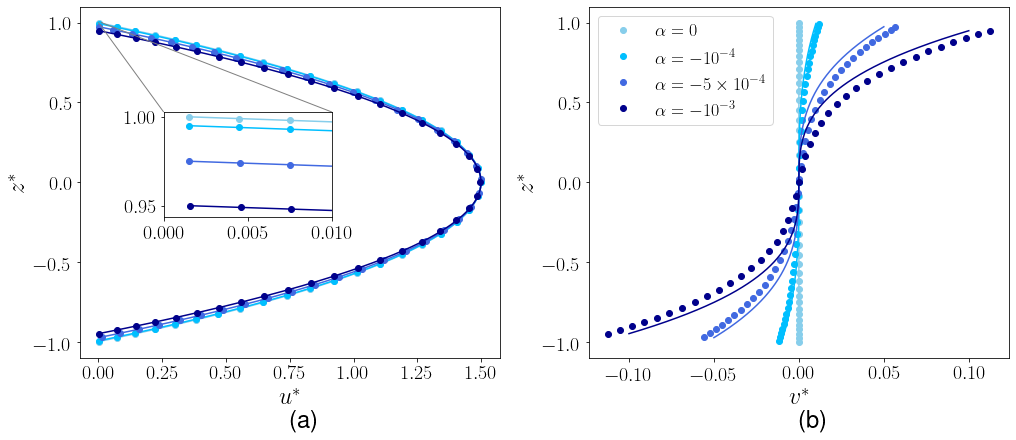

In [61]:
# Plot velocities along z-direction at different alpha and phi values

alpha = [0, -0.0001,-0.0005,-0.001]
phi = [0,0.0005, 0.001,0.005] 

eps = 0.01
Re = 1

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
colors = ['skyblue','deepskyblue','royalblue','darkblue']
figwidth = 14
figheight = 6
fig = plt.figure(figsize=(figwidth,figheight),constrained_layout=True)
widths = [figwidth/2, figwidth/2]
heights = [figheight]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

for col in range(2):
    axes[col] = fig.add_subplot(spec[0, col])

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(axes[0], [0.2,0.4,0.4,0.3])
ax2.set_axes_locator(ip)
mark_inset(axes[0], ax2, loc1=2, loc2=1, fc="none", ec='0.5')

for geo_id in range(4):
    for phi_id in range(1,2):
        color = colors[geo_id]
        alpha_ = alpha[geo_id]
        phi_ = phi[phi_id]
        Re_ = 1
        re_id = 0

        fileName = "finalData/dat_phi/geo"+str(geo_id)+ "phi" + str(phi_id)+"nu"+str(re_id) \
                    +"_up.dat"
        data = Avg_val(fileName,Re_)
        u_norm = data.iloc[50]['Ux']
        fileName = "finalData/vels_phi/U_alongZgeo" + str(geo_id)+"phi"+str(phi_id)+"nu"+\
                    str(re_id)+".xy"
            
        z_coord = []
        u = []
        v = []
        with open(fileName) as f:
             for line in f:
                z, ux, _, uz = line.split()
                z_coord.append(float(z))
                u.append(float(ux))
                v.append(float(uz)/eps)
#         print(u)
        if geo_id == 0:
            axes[1].plot(v[::5]/u_norm,z_coord[::5],'o', color = color,
                     label = r"$\alpha = 0$")
        elif geo_id == 1:                
            axes[1].plot(v[::5]/u_norm,z_coord[::5],'o', color = color,
                        label = r"$\alpha =- 10^{-4}$")

        elif geo_id == 2:
            axes[1].plot(v[::5]/u_norm,z_coord[::5],'o', color = color,
                         label = r"$\alpha =-5\times10^{-4}$")
        else:
            axes[1].plot(v[::5]/u_norm,z_coord[::5],'o', color = color,
                         label = r"$\alpha =-10^{-3}$")

        axes[0].plot(u[::5]/u_norm,z_coord[::5],'o', color = color)
        axes[1].legend(loc = 0,fontsize = 18)


        full_h = 1 + alpha_/eps*0.5

        iz = np.linspace(full_h,-full_h,2000)
#             print(iz[:5])

        full_dpdx = -3/(3*phi_*full_h + full_h**2)
        full_dpdx2 = (9*phi_ + 6*full_h)*alpha_/eps/(3*phi_*full_h + full_h**2)**2
        vt = (full_h + phi_)*alpha_/eps*full_dpdx*iz - \
        ((iz**3/6 - full_h**2*iz/2-phi_*full_h*iz))*full_dpdx2 

        u0 = -full_dpdx*(0.5*(full_h**2-iz**2)+phi_*full_h)

        u1 = ((0.5*full_h**2 + phi_*full_h)**2*(iz**2-full_h**2)*0.5 \
                   + (iz**6-full_h**6)/360)*full_dpdx*full_dpdx2 \
            + ((0.5*full_h**2 + phi_*full_h)*(iz**2-full_h**2)*0.5 \
               + (iz**4-full_h**4)/24)*(full_h+phi_)*alpha_/eps*full_dpdx**2

        ut = u0 + eps*Re_*u1  
        axes[1].plot(vt,iz,'-', color = color )
        axes[0].plot(ut,iz,'-', color = color)
        ax2.plot(ut[:5],iz[:5],'-o', color = color)
        ax2.set_xlim([0,0.01])

axes[1].set_xlabel(r"$v^*$",fontsize = 'large')
axes[0].set_xlabel(r"$u^*$",fontsize = 'large')
axes[1].set_ylabel(r"$z^*$",fontsize = 'large')
axes[0].set_ylabel(r"$z^*$",fontsize = 'large');

import string
for n, ax in enumerate(axes):
    ax.text(0.5, -0.2, "(" + string.ascii_lowercase[n]+")", transform=ax.transAxes, 
                size='large', weight='bold')

figure_folder = "./finalData/"
figure_name = "vels.pdf"
figure_file_path = figure_folder + figure_name
plt.savefig(figure_file_path)

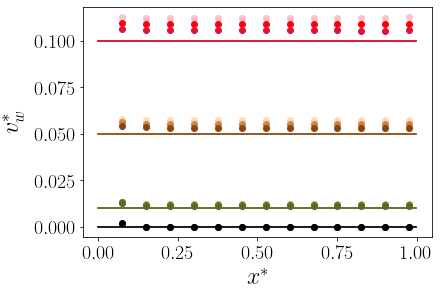

In [80]:
# Plot permeation velocity
figwidth       = 6
figheight      = 4
colors =  [['black', 'dimgray','lightgrey'],
          ['darkolivegreen','olive','darkkhaki'],
          ['saddlebrown','peru','peachpuff'],
           ['crimson' ,'red','pink']]
eps = 0.01
fig = plt.figure(figsize=(figwidth,figheight),constrained_layout=True)
alpha = [0, -0.0001,-0.0005,-0.001]
phi = [0,0.0005, 0.001,0.005] 

for geo_id in range(4):
    for phi_id in range(2,-1,-1):

        color = colors[geo_id][phi_id]
        # simulation
        df = pd.read_csv('./finalData/vels_phi/geo'+ str(geo_id)+'phi' + str(phi_id) + 'nu0_vw.csv', 
                         header=None)
        df.columns = ['x','vw','z']
        df = df[:400]
        plt.plot(df['x'][30::30]*eps,df['vw'][30::30]/eps,'o',color = color)
        
        # theory
        df['vw_t'] = -df['z']*alpha[geo_id]/eps/(3*phi[phi_id] + df['z'])
        plt.plot(df['x']*eps,df['vw_t'],'-',color = color)
        
plt.xlabel(r'$x^*$',fontsize = 'large')
plt.ylabel(r'$v_w^*$',fontsize = 'large')

figure_name = "permeation.pdf"
figure_folder = "./finalData/"
figure_file_path = figure_folder + figure_name
plt.savefig(figure_file_path)

# 3. Conductivity

In [84]:
# Theoretical solution of conductivity (non-dimensional)
def THEO_coeff(alpha,phi,Re):
    
    c1 = (3*phi+1)/3
    c2 = (3+22*phi+28*phi**2)/(35*(3*phi+1)**2)
    eps = 0.01
    xnew = np.arange(0,1.01,0.1)
    
    n = np.size(xnew)
    slop_t = []
    dpdx = []
    u = []
    delta = alpha/eps
    h = 1 + delta*xnew
    
    for i in range(n):

#         slop = c1 + (2.0/3.0*xnew[i] + phi*xnew[i] - c2*Re*eps)*delta
        h_ = h[i]
        slop = (3*phi*h_ + h_**2)/3 - eps*Re*h_**3*(28*phi**2 + 22*phi*h_+3*h_**2)*delta/(3*phi+h_**2)/35
        
        slop_t.append(slop)

    return slop_t

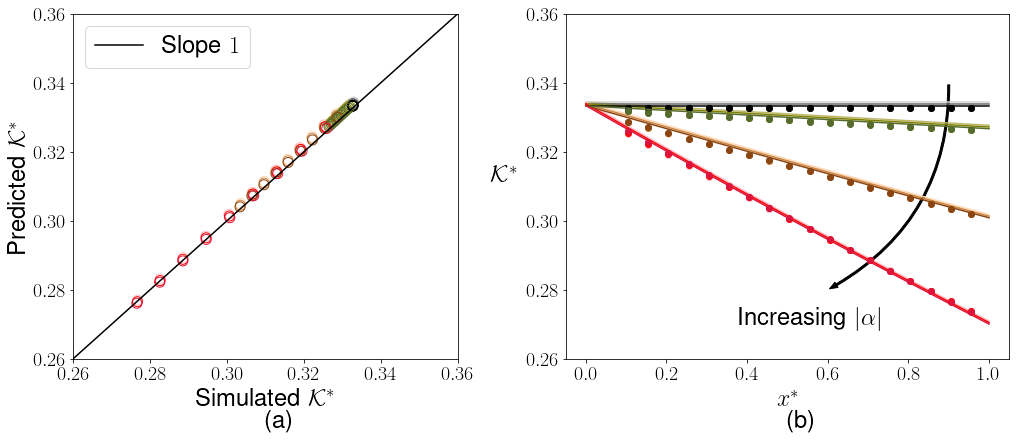

In [92]:
import matplotlib.patches as patches
figwidth       = 14
figheight      = 6

alpha = [0, -0.0001,-0.0005,-0.001]
phi = [0,0.0005, 0.001,0.005] 
eps = 0.01
Re = [1]

fig = plt.figure(figsize=(figwidth,figheight),constrained_layout=True)
widths = [figheight+0.5, figwidth-figheight-0.5]
heights = [figheight]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

for col in range(2):
    axes[col] = fig.add_subplot(spec[0, col])

xnew = np.arange(0,100,0.5)
colors = [['black', 'dimgray','lightgrey'],
          ['darkolivegreen','olive','darkkhaki'],
          ['saddlebrown','peru','peachpuff'],
          ['crimson' ,'red','pink']          
]

xnew = np.arange(0,1.1,0.1)
xline = np.arange(0.26,0.361,0.01)
yline = xline
axes[0].plot(xline,yline, color = 'k',label = r"Slope $1$")
re_id = 0
for phi_id in range(2,-1,-1):
    for a_id in range(4): 

        # scatter plot    
        color = colors[a_id][phi_id]
        fileName = "finalData/dat_phi/geo"+ str(a_id)+ "phi" + str(phi_id)+"nu"+str(re_id)+"_up.dat"
        data = Avg_val(fileName,Re[re_id])
        x = data['conductivity'][10::10].values
        y = THEO_coeff(alpha[a_id],phi[phi_id],1)
        axes[0].scatter(x, y[1:-1], color = color, marker = 'o', facecolors='none', s=100);

        # conductivity plot
        fileName = "finalData/dat_phi/geo"+str(a_id)+ "phi" + str(phi_id)+"nu"+str(re_id)+"_up.dat"
        data = Avg_val(fileName,Re[re_id])
        axes[1].plot(data['Coord'][10::5]*0.01,data['conductivity'][10::5],'o',color = color)
        kappa_t = THEO_coeff(alpha[a_id],phi[phi_id],Re[re_id])
        axes[1].plot(xnew, kappa_t,color =color)

axes[0].set_ylim(0.26, 0.36)
axes[0].set_xlim(0.26, 0.36)
axes[0].legend(loc=2, fontsize = 'large')
axes[0].set_xlabel(r"Simulated $\mathcal{K}^*$",fontsize='large')
axes[0].set_ylabel(r"Predicted $\mathcal{K}^*$",fontsize='large')


# ## Add arrow
style="Simple,tail_width=2,head_width=6,head_length=8"
kw2 = dict(arrowstyle=style, color="k")
a = patches.FancyArrowPatch((.90,0.34), (.60,0.28),connectionstyle="arc3,rad=-.3", **kw2)
plt.gca().add_patch(a)

axes[1].set_xlabel(r"$x^*$",fontsize = 'large')
axes[1].set_ylabel(r"$\mathcal{K}^*$",rotation=0,fontsize = 'large')
axes[1].xaxis.set_ticks(np.arange(0,1.1,0.2))
axes[1].yaxis.set_ticks(np.arange(0.26,0.365,0.02))
axes[1].tick_params(axis='both', which='major')
axes[1].yaxis.set_label_coords(-0.14,0.5)

import string
for n, ax in enumerate(axes):
    ax.text(0.5, -0.2, "(" + string.ascii_lowercase[n]+")", transform=ax.transAxes, 
                size='large', weight='bold')


# Add text box 
axes[1].text(0.38, 0.27, r'Increasing $\left|\alpha \right |$',fontsize = 'large')
figure_name = "conductivity.pdf"
figure_folder = "./finalData/"
figure_file_path = figure_folder + figure_name
plt.savefig(figure_file_path)